In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [3]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=1000.0,
        desired_opinion=0.9,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


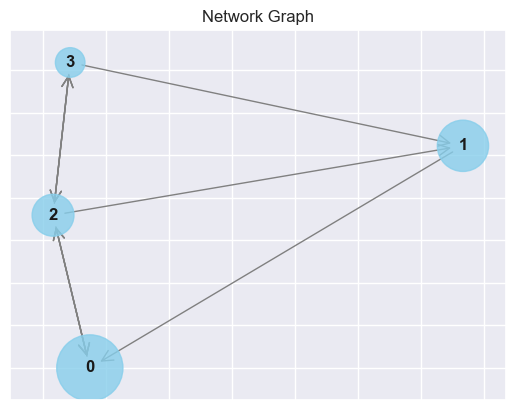

In [4]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


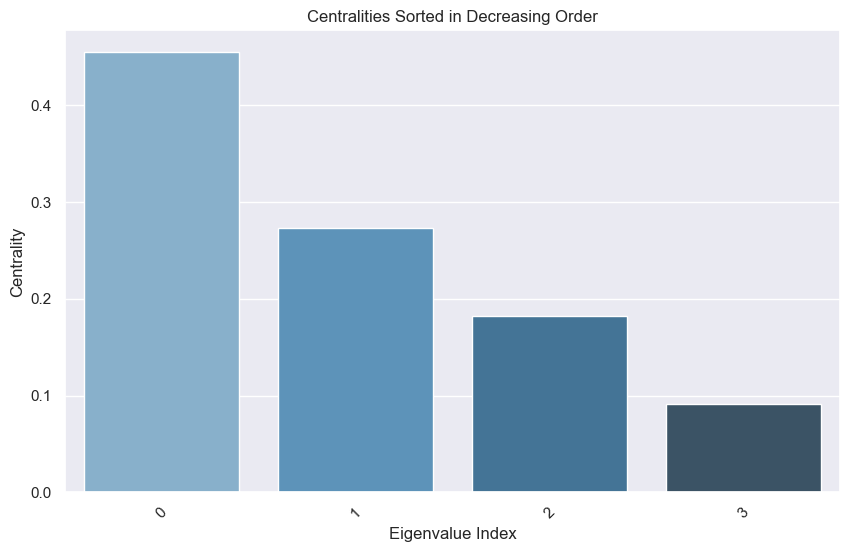

In [5]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.4204647904080085
Final Error: 0.4120701748735516


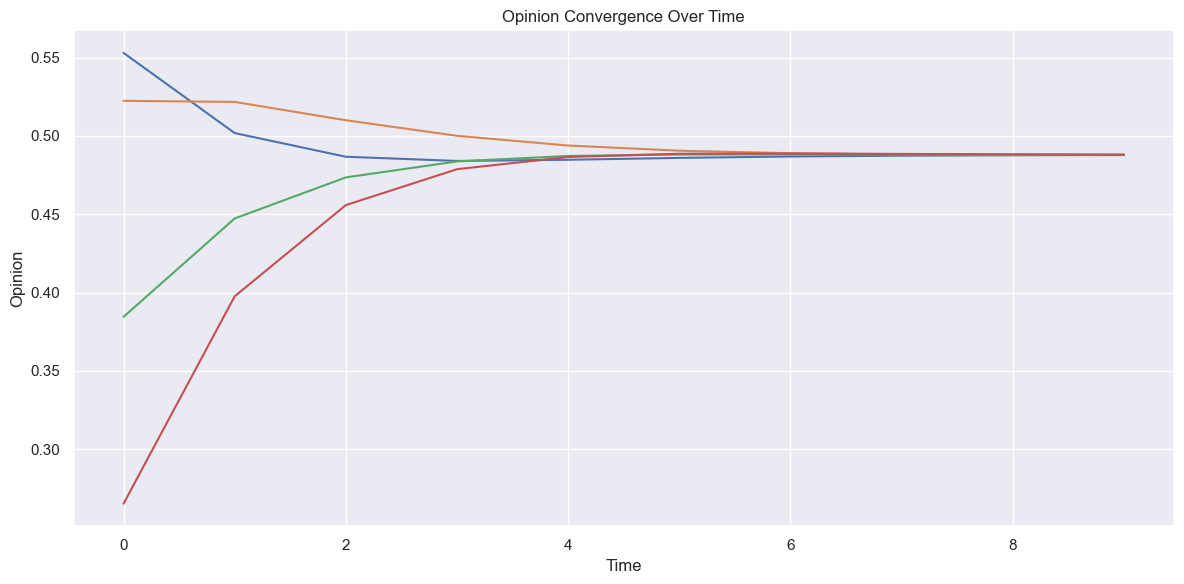

In [6]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Overall Error: 0.33637183232640677
Final Error: 0.32965613989884124


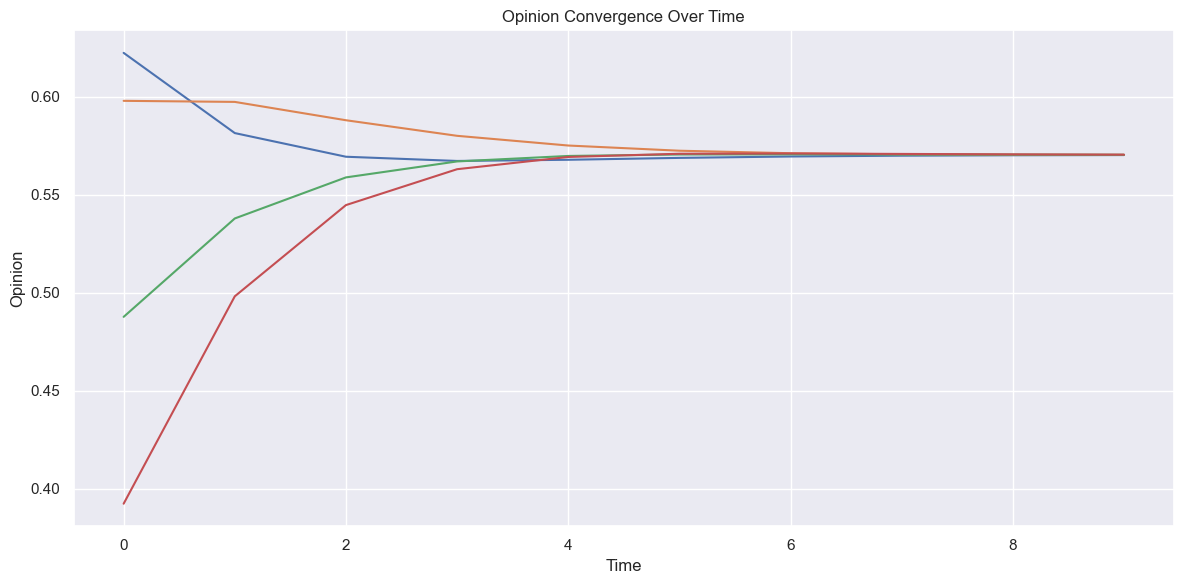

In [7]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    if i == 0:
        action_u = np.ones(env.num_agents) * env.max_u 
        opinions, reward, done, truncated, info = env.step(action_u)
        opinions_over_time[i] = opinions
    else:
        no_action_u = np.zeros(env.num_agents)  # Zero control input
        opinions, reward, done, truncated, info = env.step(no_action_u)
        opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

### Baseline 

Simulation stopped after 17 campaigns.

Policy Strategy - Overall Error: 0.0966905741859627
Final Error: 0.009280144686703906


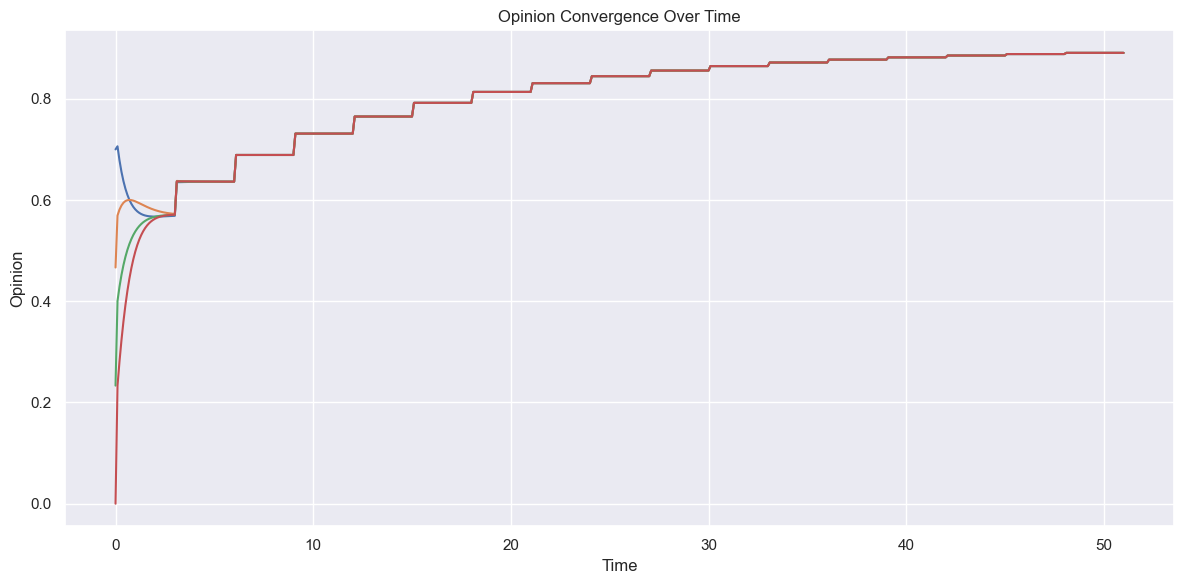

In [8]:
from algos import run_policy_campaigns, generate_full_control_policy



# Assuming create_state_grid and other necessary functions are defined
# Example Usage
env = init_env()
step_duration = 3  # Duration of each campaign
sampling_time = 0.1  # Sampling interval during each campaign
tolerance = 0.01  # Stopping criterion for mean opinion
nx = 5  # Number of grid points per dimension
max_campaigns = 100

# Compute the policy using value iteration
policy = generate_full_control_policy(env, nx)

# Run the campaigns using the policy
opinions_over_time, time_points, nodes_controlled_simulation = run_policy_campaigns(
    env, policy, nx, step_duration, sampling_time, tolerance, max_campaigns
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"\nPolicy Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot the opinions over time (ensure you have the plotting function defined)
plot_opinions_over_time(opinions_over_time, time_points)


In [9]:
# viz: per node, one axis mean of network, one axis opinion in node, represent taken action

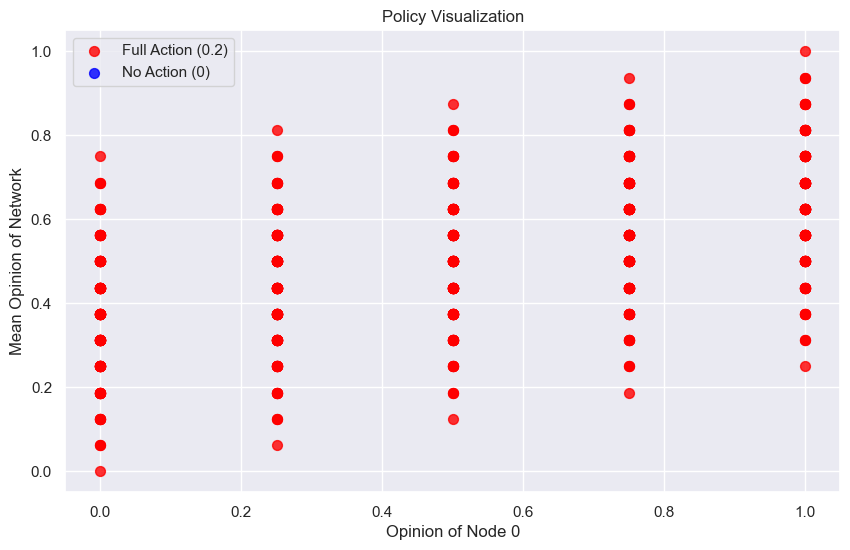

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy_from_env(policy, env, nx, node_index):
    """
    Visualize the policy with respect to the value of a specific node and mean opinion of the network.
    
    Args:
        policy (dict): Mapping from state indices to actions.
        env: The environment with network properties.
        nx (int): Number of grid points per dimension.
        node_index (int): The index of the node to visualize.
    """
    # Define the state grid: opinions range from 0 to 1
    N = env.num_agents  # Number of agents
    grids = [np.linspace(0, 1, nx) for _ in range(N)]  # Uniform grid in [0, 1]

    node_opinions = []  # X-axis: Opinion of the specific node
    mean_opinions = []  # Y-axis: Mean opinion of the network
    actions = []        # Full action (0.2) or no action (0)

    for idx, action in policy.items():
        # Map state indices to grid values
        state = [grids[i][idx[i]] for i in range(N)]
        node_opinion = state[node_index]  # Opinion of the specific node
        mean_opinion = np.mean(state)    # Mean opinion of the network
        
        node_opinions.append(node_opinion)
        mean_opinions.append(mean_opinion)
        actions.append(np.any(action))  # 1 if full action (0.2), 0 if no action

    # Map actions to two colors
    colors = ['red' if a else 'blue' for a in actions]

    # Scatter plot
    plt.figure(figsize=(10, 6))
    for color, label in zip(['red', 'blue'], ['Full Action (0.2)', 'No Action (0)']):
        subset_idx = [i for i, c in enumerate(colors) if c == color]
        plt.scatter(np.array(node_opinions)[subset_idx], 
                    np.array(mean_opinions)[subset_idx], 
                    c=color, label=label, s=50, alpha=0.8)

    plt.xlabel(f"Opinion of Node {node_index}")
    plt.ylabel("Mean Opinion of Network")
    plt.title("Policy Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `policy` is created by `generate_full_control_policy` and `env` is initialized.
node_index = 0  # Choose a node to visualize
visualize_policy_from_env(policy, env, nx=5, node_index=node_index)


### Infinite horizon

In [ ]:
import numpy as np
from itertools import product
from scipy.linalg import expm

def create_state_grid(N, nx):
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def initialize_value_function(N, nx):
    grid_shape = tuple([nx] * N)
    return np.zeros(grid_shape)

def reward_function(x, u, d, beta):
    return - np.abs(d - x).sum() - beta * np.sum(u)

def value_iteration(env, nx=10, gamma=1.0, beta=0.0, step_duration=3.0, max_iterations=1000, tol=1e-6):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    V = initialize_value_function(N, nx)

    control_actions = list(product([0, ubar], repeat=N))

    for iteration in range(max_iterations):
        V_new = np.zeros_like(V)
        max_diff = 0

        for idx in np.ndindex(grid_shape):
            current_state = np.array([grids[i][idx[i]] for i in range(N)])
            best_value = -np.inf

            for control in control_actions:
                control_input = np.array(control)
                next_state = env.compute_dynamics(current_state, control_input, step_duration)
                next_state = np.clip(next_state, 0, 1)

                next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
                future_value = V[next_idx]
                immediate_reward = reward_function(current_state, control_input, d, beta)

                total_value = immediate_reward + gamma * future_value
                if total_value > best_value:
                    best_value = total_value

            V_new[idx] = best_value
            max_diff = max(max_diff, abs(V_new[idx] - V[idx]))

        if max_diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        V = V_new

    return V

def extract_policy(env, V, nx=10, gamma=1.0, beta=0.0, step_duration=3.0):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    control_actions = list(product([0, ubar], repeat=N))
    policy = {}

    for idx in np.ndindex(grid_shape):
        current_state = np.array([grids[i][idx[i]] for i in range(N)])
        best_value = -np.inf
        best_action = None

        for control in control_actions:
            control_input = np.array(control)
            next_state = env.compute_dynamics(current_state, control_input, step_duration)
            next_state = np.clip(next_state, 0, 1)

            next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
            future_value = V[next_idx]
            immediate_reward = reward_function(current_state, control_input, d, beta)
            total_value = immediate_reward + gamma * future_value

            if total_value > best_value:
                best_value = total_value
                best_action = control_input

        policy[idx] = best_action if best_action is not None else np.zeros(N)

    return policy

# Adjusted parameters
beta = 0.0
gamma = 0.99
step_duration = 3
nx = 4  # Increased grid resolution

# Run value iteration and extract policy
V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
policy = extract_policy(env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)


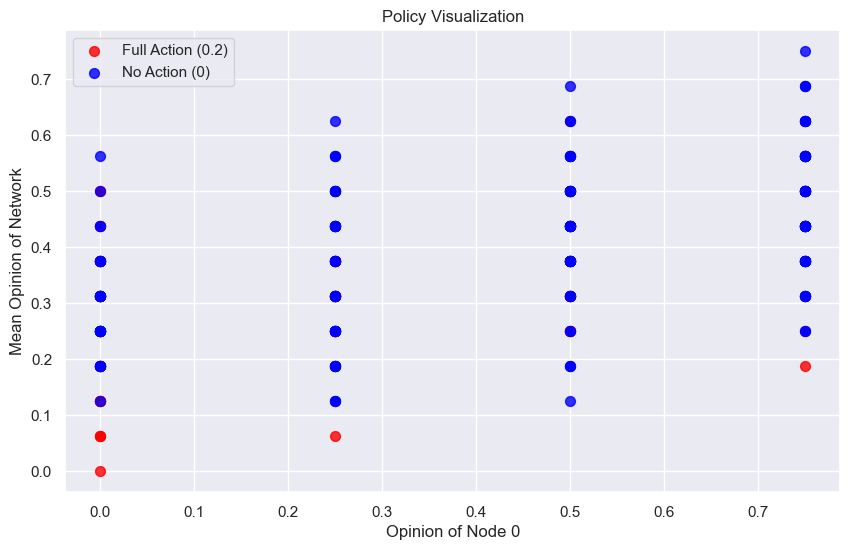

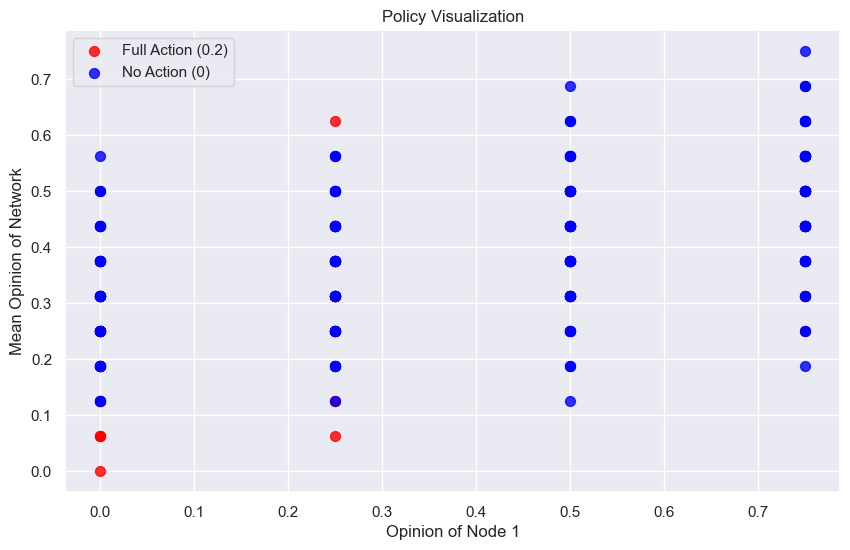

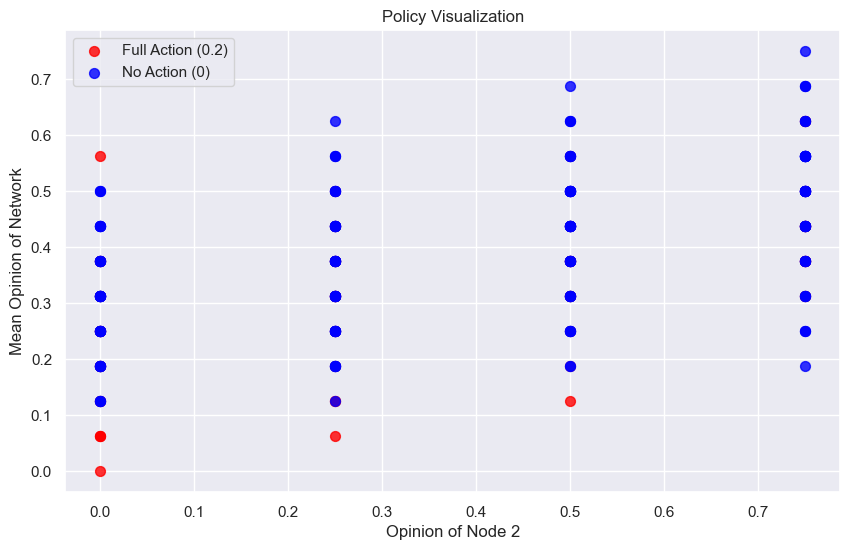

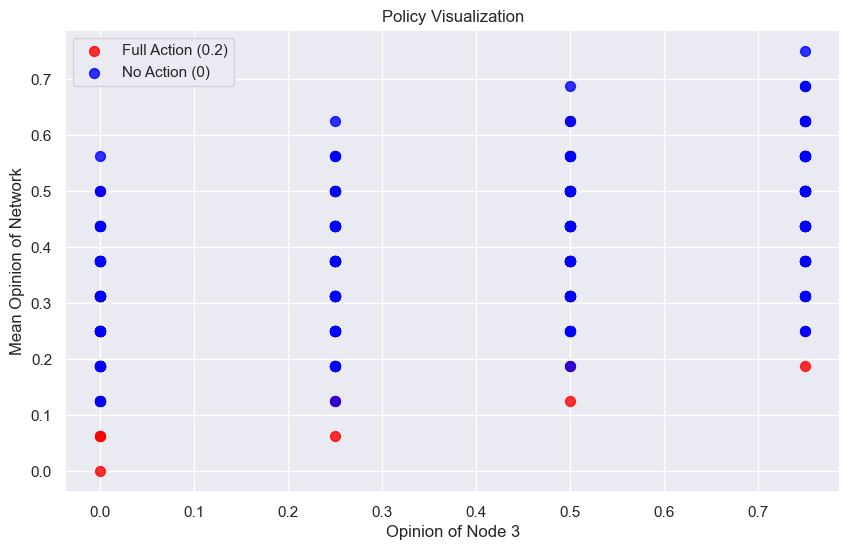

In [12]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=5, node_index=node_index)

In [13]:
policy[(3, 3, 3, 3)]

array([0, 0, 0, 0])

In [14]:
# Run the campaigns using the policy
opinions_over_time, time_points, nodes_controlled_simulation = run_policy_campaigns(
    env, policy, nx, step_duration, sampling_time, tolerance
)

# Compute error
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)


Maximum number of campaigns reached.
Simulation stopped after 100 campaigns.


In [15]:
raise NotImplementedError

NotImplementedError: 

In [ ]:
# results_sorted_by_error